In [37]:
#ignore above this

# form4_pipeline.py

import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
from pandas.tseries.offsets import BDay
import yfinance as yf

BASE_URL = "https://www.sec.gov/"
HEADERS = {'User-Agent': 'Your Name your_email@example.com'}  # Replace with real name/email per SEC guidance

# SEC CIK lookup table (symbol to CIK)
def load_cik_map():
    url = "https://www.sec.gov/files/company_tickers.json"
    resp = requests.get(url, headers=HEADERS)
    data = resp.json()
    cik_map = {
        v['ticker'].upper(): str(v['cik_str']).zfill(10)
        for v in data.values()
    }
    return cik_map

# Get Form 4 filings for a specific CIK over the past N days
def get_recent_form4s(cik, days_back=30):
    base_url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    r = requests.get(base_url, headers=HEADERS)
    if r.status_code != 200:
        return None
    filings = r.json().get("filings", {}).get("recent", {})
    df = pd.DataFrame(filings)
    df = df[df['form'] == '4']
    df['filingDate'] = pd.to_datetime(df['filingDate'], utc=True)
    df = df[df['filingDate'] > (datetime.now(timezone.utc) - timedelta(days=days_back))]
    df['accession_url'] = df['accessionNumber'].apply(
        lambda x: f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{x.replace('-', '')}/{x}-index.htm")
    return df[['accessionNumber', 'filingDate', 'accession_url']]

# Example run for a few tickers
def batch_fetch_form4s(tickers):
    cik_map = load_cik_map()
    output = []
    for ticker in tickers:
        cik = cik_map.get(ticker.upper())
        if not cik:
            continue
        print(f"Fetching Form 4s for {ticker} (CIK {cik})")
        df = get_recent_form4s(cik)
        if df is not None and not df.empty:
            df['ticker'] = ticker
            output.append(df)
        time.sleep(0.25)
    return pd.concat(output) if output else pd.DataFrame()

# Pull price data using yfinance
def fetch_price_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# Merge form4 events with forward price performance
def attach_forward_returns(df_form4s, window=30):
    result_rows = []
    for ticker in df_form4s['ticker'].unique():
        df_ticker = df_form4s[df_form4s['ticker'] == ticker]
        min_date = df_ticker['filingDate'].min().date() - timedelta(days=1)
        max_date = df_ticker['filingDate'].max().date() + timedelta(days=window+2)
        price_df = fetch_price_data(ticker, min_date, max_date)
        if price_df.empty:
            continue
        price_df = price_df[['Close']].rename(columns={'Close': 'close'})
        price_df.index = pd.to_datetime(price_df.index)

        for _, row in df_ticker.iterrows():
            event_date = row['filingDate'].date()
            try:
                event_ts = price_df.index[price_df.index.get_indexer([pd.Timestamp(event_date)], method='nearest')[0]]
                fwd_ts = event_ts + BDay(window)
                if fwd_ts not in price_df.index:
                    continue
                start_price = price_df.loc[event_ts, 'close']
                fwd_price = price_df.loc[fwd_ts, 'close']
                fwd_return = (fwd_price - start_price) / start_price
                result_rows.append({
                    'ticker': str(ticker),
                    'filingDate': row['filingDate'].date(),
                    'start_price': float(start_price),
                    'fwd_price': float(fwd_price),
                    'fwd_return': float(fwd_return)
                })
            except Exception as e:
                print(f"Failed for {ticker} on {event_date}: {e}")
                continue
    return pd.DataFrame(result_rows)

if __name__ == '__main__':
    daysfwd = 10  # Set forward return window
    tickers = ['AAPL', 'TSLA', 'NVDA', 'META']  # Replace or expand
    df_form4s = batch_fetch_form4s(tickers)
    print(df_form4s.head())

    df_returns = attach_forward_returns(df_form4s, window=10)
    print("\nForward Return Samples:")
    print(df_returns.head())


Fetching Form 4s for AAPL (CIK 0000320193)
Fetching Form 4s for TSLA (CIK 0001318605)
Fetching Form 4s for NVDA (CIK 0001045810)
Fetching Form 4s for META (CIK 0001326801)


[*********************100%***********************]  1 of 1 completed

        accessionNumber                filingDate  \
0  0001104659-25-068165 2025-07-15 00:00:00+00:00   
2  0001104659-25-066775 2025-07-09 00:00:00+00:00   
2  0001197649-25-000010 2025-07-18 00:00:00+00:00   
4  0001588670-25-000003 2025-07-17 00:00:00+00:00   
7  0001045810-25-000190 2025-07-15 00:00:00+00:00   

                                       accession_url ticker  
0  https://www.sec.gov/Archives/edgar/data/131860...   TSLA  
2  https://www.sec.gov/Archives/edgar/data/131860...   TSLA  
2  https://www.sec.gov/Archives/edgar/data/104581...   NVDA  
4  https://www.sec.gov/Archives/edgar/data/104581...   NVDA  
7  https://www.sec.gov/Archives/edgar/data/104581...   NVDA  



[*********************100%***********************]  1 of 1 completed
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_44216\4106495140.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'start_price': float(start_price),
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_44216\4106495140.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'fwd_price': float(fwd_price),
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_44216\4106495140.py:89: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'fwd_return': float(fwd_return)
[*********************100%***********************]  1 of 1 completed


Forward Return Samples:
  ticker  filingDate  start_price   fwd_price  fwd_return
0   NVDA  2025-07-07   158.240005  171.380005    0.083038
1   NVDA  2025-07-07   158.240005  171.380005    0.083038
2   NVDA  2025-07-01   153.300003  170.699997    0.113503
3   NVDA  2025-07-01   153.300003  170.699997    0.113503
4   NVDA  2025-06-30   157.990005  164.070007    0.038483



C:\Users\John DeForest\AppData\Local\Temp\ipykernel_44216\4106495140.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'start_price': float(start_price),
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_44216\4106495140.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'fwd_price': float(fwd_price),
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_44216\4106495140.py:89: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'fwd_return': float(fwd_return)


In [46]:
# form4_pipeline.py

import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
from pandas.tseries.offsets import BDay
import yfinance as yf
import xml.etree.ElementTree as ET

BASE_URL = "https://www.sec.gov/"
HEADERS = {'User-Agent': 'Your Name your_email@example.com'}  # Replace with real name/email per SEC guidance

# SEC CIK lookup table (symbol to CIK)
def load_cik_map():
    url = "https://www.sec.gov/files/company_tickers.json"
    print("Fetching CIK mapping...")
    resp = requests.get(url, headers=HEADERS)
    data = resp.json()
    cik_map = {
        v['ticker'].upper(): str(v['cik_str']).zfill(10)
        for v in data.values()
    }
    print(f"Loaded {len(cik_map)} tickers from SEC mapping.")
    return cik_map

# Parse Form 4 XML filings to extract BUY transactions
def get_recent_form4s(cik, ticker, days_back=90):
    url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    print(f"Pulling Form 4 JSON for {ticker} (CIK {cik})...")
    r = requests.get(url, headers=HEADERS)
    if r.status_code != 200:
        print(f"Failed to retrieve data for {ticker} (status code {r.status_code})")
        return None
    data = r.json()
    accession_nums = data.get("filings", {}).get("recent", {}).get("accessionNumber", [])
    filing_dates = data.get("filings", {}).get("recent", {}).get("filingDate", [])
    forms = data.get("filings", {}).get("recent", {}).get("form", [])
    print(f"Found {len(accession_nums)} recent filings for {ticker}")

    rows = []
    for acc_num, fdate, form_type in zip(accession_nums, filing_dates, forms):
        if form_type != '4':
            continue
        filing_dt = pd.to_datetime(fdate, utc=True)
        if filing_dt < (datetime.now(timezone.utc) - timedelta(days=days_back)):
            continue
        xml_url = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{acc_num.replace('-', '')}/{acc_num}.xml"
        print(f"Parsing XML: {xml_url}")
        try:
            xml_resp = requests.get(xml_url, headers=HEADERS)
            tree = ET.fromstring(xml_resp.content)
            for txn in tree.findall(".//nonDerivativeTransaction"):
                code = txn.findtext("transactionCoding/transactionCode")
                if code != 'P':  # Only BUY transactions
                    continue
                shares = txn.findtext("transactionAmounts/transactionShares")
                price = txn.findtext("transactionAmounts/transactionPricePerShare")
                date = txn.findtext("transactionDate/value")
                if not all([shares, price, date]):
                    continue
                rows.append({
                    'ticker': ticker,
                    'filingDate': pd.to_datetime(date),
                    'shares': float(shares),
                    'price_per_share': float(price),
                    'accession_url': f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{acc_num.replace('-', '')}/{acc_num}-index.htm"
                })
        except Exception as e:
            print(f"Failed to parse {acc_num} for {ticker}: {e}")
            continue
    print(f"Extracted {len(rows)} BUY transactions for {ticker}")
    return pd.DataFrame(rows)

# Fetch Form 4s using XML parser
def batch_fetch_form4s(tickers):
    cik_map = load_cik_map()
    output = []
    for ticker in tickers:
        cik = cik_map.get(ticker.upper())
        if not cik:
            print(f"No CIK found for {ticker}")
            continue
        print(f"Fetching Form 4 BUYs for {ticker} (CIK {cik})")
        df = get_recent_form4s(cik, ticker)
        if df is not None and not df.empty:
            output.append(df)
        else:
            print(f"No valid BUY transactions found for {ticker}.")
        time.sleep(0.5)
    return pd.concat(output) if output else pd.DataFrame()

# Pull price data using yfinance
def fetch_price_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# Merge form4 events with forward price performance
def attach_forward_returns(df_form4s, window=10):
    result_rows = []
    for ticker in df_form4s['ticker'].unique():
        df_ticker = df_form4s[df_form4s['ticker'] == ticker]
        min_date = df_ticker['filingDate'].min().date() - timedelta(days=1)
        max_date = df_ticker['filingDate'].max().date() + timedelta(days=window+2)
        price_df = fetch_price_data(ticker, min_date, max_date)
        if price_df.empty:
            continue
        price_df = price_df[['Close']].rename(columns={'Close': 'close'})
        price_df.index = pd.to_datetime(price_df.index)

        for _, row in df_ticker.iterrows():
            event_date = row['filingDate'].date()
            try:
                event_ts = price_df.index[price_df.index.get_indexer([pd.Timestamp(event_date)], method='nearest')[0]]
                fwd_ts = event_ts + BDay(window)
                if fwd_ts not in price_df.index:
                    continue
                start_price = price_df.loc[event_ts, 'close']
                fwd_price = price_df.loc[fwd_ts, 'close']
                fwd_return = (fwd_price - start_price) / start_price
                result_rows.append({
                    'ticker': str(ticker),
                    'filingDate': row['filingDate'].date(),
                    'shares': float(row['shares']),
                    'price_per_share': float(row['price_per_share']),
                    'start_price': float(start_price),
                    'fwd_price': float(fwd_price),
                    'fwd_return': float(fwd_return)
                })
            except Exception as e:
                print(f"Failed for {ticker} on {event_date}: {e}")
                continue
    return pd.DataFrame(result_rows)

if __name__ == '__main__':
    #tickers = ['AAPL', 'TSLA', 'NVDA', 'META']  # Replace or expand
    tickers = ['KRNY', 'HROW', 'RILY', 'CLFD','MGIC','BLBD']
    df_form4s = batch_fetch_form4s(tickers)
    print("\nForm 4 BUY Transactions:")
    print(df_form4s.head())

    df_returns = attach_forward_returns(df_form4s, window=10)
    print("\nForward Return Samples:")
    print(df_returns.head())


Fetching CIK mapping...
Loaded 10068 tickers from SEC mapping.
Fetching Form 4 BUYs for KRNY (CIK 0001617242)
Pulling Form 4 JSON for KRNY (CIK 0001617242)...
Found 565 recent filings for KRNY
Parsing XML: https://www.sec.gov/Archives/edgar/data/1617242/000161724225000020/0001617242-25-000020.xml
Parsing XML: https://www.sec.gov/Archives/edgar/data/1617242/000161724225000018/0001617242-25-000018.xml
Parsing XML: https://www.sec.gov/Archives/edgar/data/1617242/000161724225000016/0001617242-25-000016.xml
Extracted 0 BUY transactions for KRNY
No valid BUY transactions found for KRNY.
Fetching Form 4 BUYs for HROW (CIK 0001360214)
Pulling Form 4 JSON for HROW (CIK 0001360214)...
Found 807 recent filings for HROW
Parsing XML: https://www.sec.gov/Archives/edgar/data/1360214/000164117225017377/0001641172-25-017377.xml
Parsing XML: https://www.sec.gov/Archives/edgar/data/1360214/000164117225017376/0001641172-25-017376.xml
Parsing XML: https://www.sec.gov/Archives/edgar/data/1360214/00016411722

KeyError: 'ticker'

In [38]:
print(df_returns.head(1))
print(171/158)

  ticker  filingDate  start_price   fwd_price  fwd_return
0   NVDA  2025-07-07   158.240005  171.380005    0.083038
1.0822784810126582


ticker          object
filingDate      object
start_price    float64
fwd_price      float64
fwd_return     float64
dtype: object
  ticker  fwd_return
0   NVDA    0.083038
1   NVDA    0.083038
2   NVDA    0.113503
3   NVDA    0.113503
4   NVDA    0.038483
ticker         0
filingDate     0
start_price    0
fwd_price      0
fwd_return     0
dtype: int64


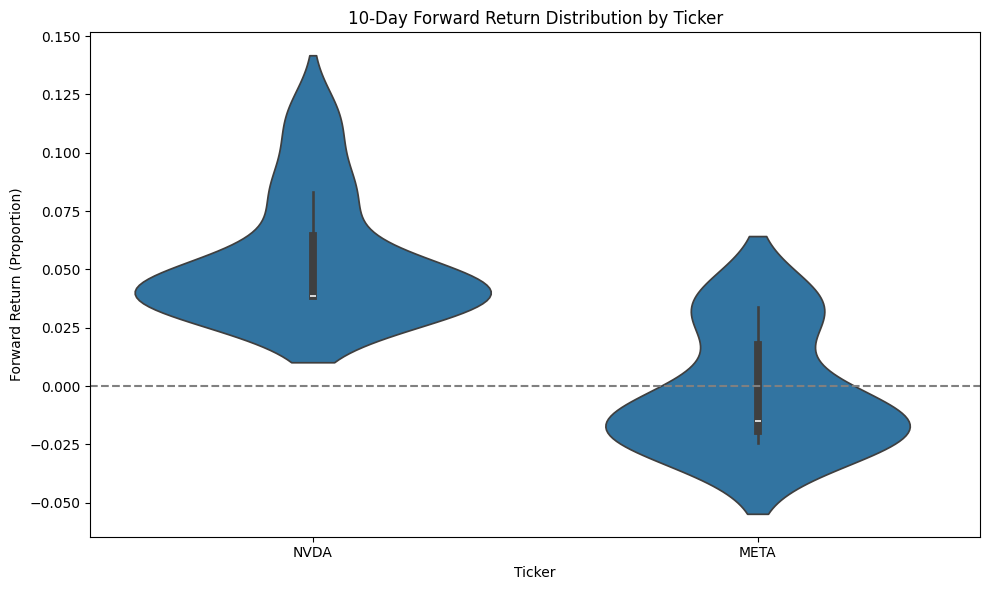

Summary Statistics by Ticker (10-Day Forward Return):
  ticker  count  mean_pct    median  std_pct       min       max
0   META     11     -0.25 -0.014939     2.45 -0.024478  0.034007
1   NVDA     20      5.43  0.038483     2.57  0.038483  0.113503


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If df_returns isn't already loaded, read from CSV or pass it from your pipeline
# df_returns = pd.read_csv("returns.csv")

print(df_returns.dtypes)
print(df_returns[['ticker', 'fwd_return']].head())
print(df_returns.isnull().sum())



# --- Visualization ---
df_plot = df_returns.dropna(subset=['ticker', 'fwd_return'])

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_plot, x='ticker', y='fwd_return')
plt.axhline(0, linestyle='--', color='gray')
plt.title(f"{daysfwd}-Day Forward Return Distribution by Ticker")
plt.ylabel("Forward Return (Proportion)")
plt.xlabel("Ticker")
plt.tight_layout()
plt.show()


# --- Summary Stats ---

summary = df_returns.groupby('ticker')['fwd_return'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()
summary['mean_pct'] = (summary['mean'] * 100).round(2)
summary['std_pct'] = (summary['std'] * 100).round(2)

print(f"Summary Statistics by Ticker ({daysfwd}-Day Forward Return):")
print(summary[['ticker', 'count', 'mean_pct', 'median', 'std_pct', 'min', 'max']])
